In [1]:
%matplotlib notebook

from IPython.display import clear_output

from NIX_Testing import NIX_Image_List, NIX_Image, doGridAnalysis, ProgressBar
from pylab import *
from astropy.io import fits
from lmfit.models import PolynomialModel
import pickle
import multiprocessing as mp

data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup'

test_ids = ['PER-124-04-1']
config = {'test_ids' : test_ids, 'data_dir' : data_dir}
NIX_GL = NIX_Image_List(config)

In [2]:
dark = 2*arange(14)
select = 2*arange(14)+40
exps = 2*arange(14)+2

angs, lins, Rs = NIX_GL.doLinearRegress(exps, select, dark=dark, cpu=6)
Rs[where(Rs < 0)] = 0
Rs = Rs**2

_multiLinearRegress ==> [####################] 100% 02:16/02:16


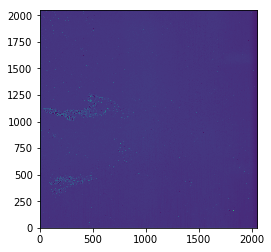

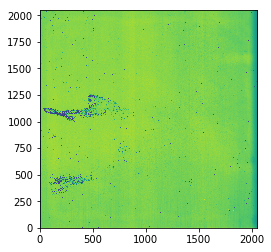

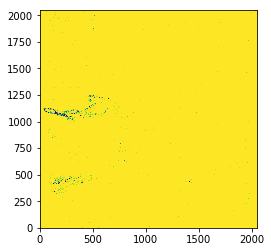

In [3]:
%matplotlib inline
figure()
imshow(lins)
gca().invert_yaxis()
fits.PrimaryHDU(lins).writeto("out/reg_lins.fits", overwrite=True)
figure()
imshow(angs)
gca().invert_yaxis()
fits.PrimaryHDU(angs).writeto("out/reg_angs.fits", overwrite=True)
figure()
imshow(Rs)
gca().invert_yaxis()
fits.PrimaryHDU(Rs).writeto("out/reg_R2.fits", overwrite=True)


In [4]:
select = 2*arange(20)+40
dark = 2*arange(20)
exps = 2*arange(20)+2
ims = NIX_GL.getImage(select=select, dark=dark)
ims2 = NIX_GL.getImage(select=select+1, dark=dark)

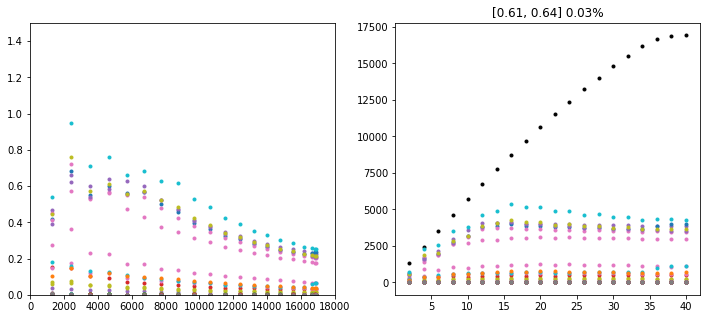

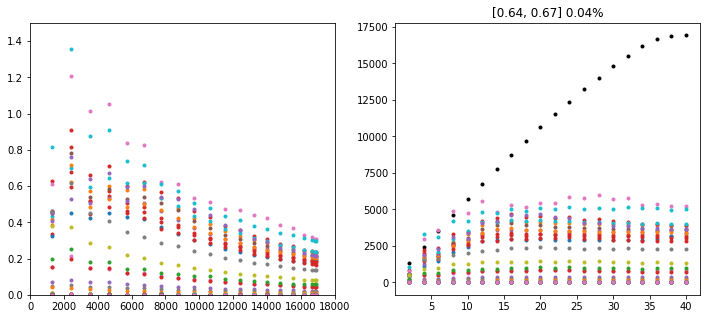

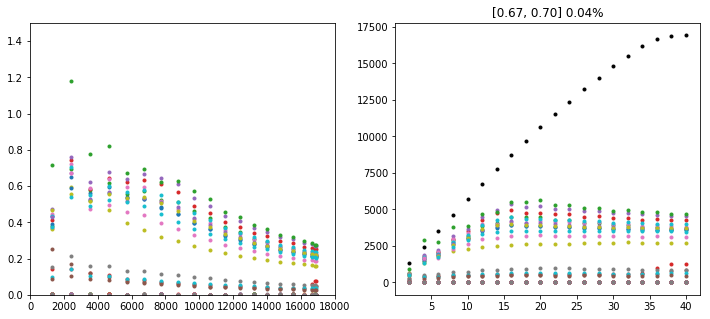

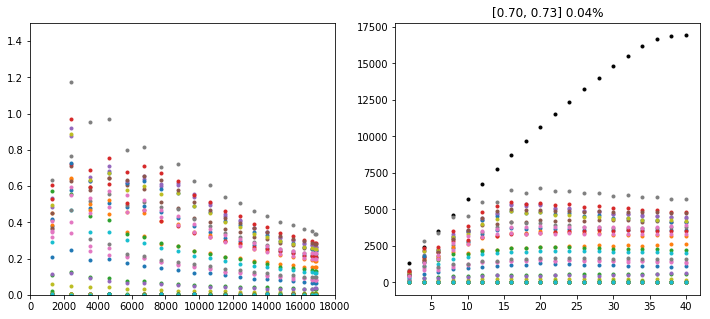

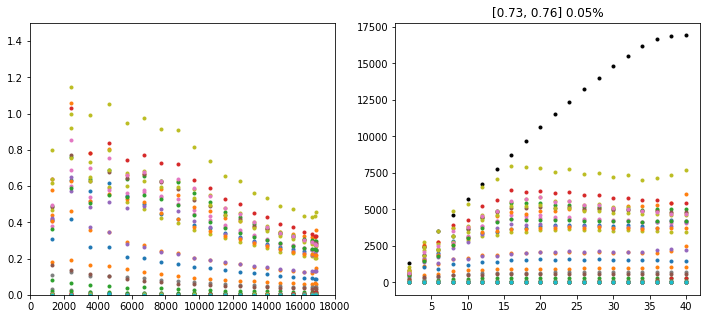

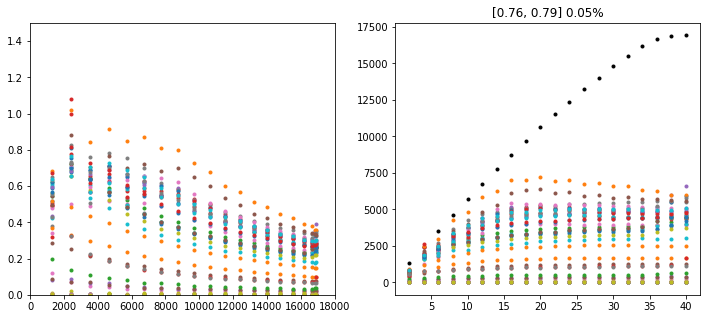

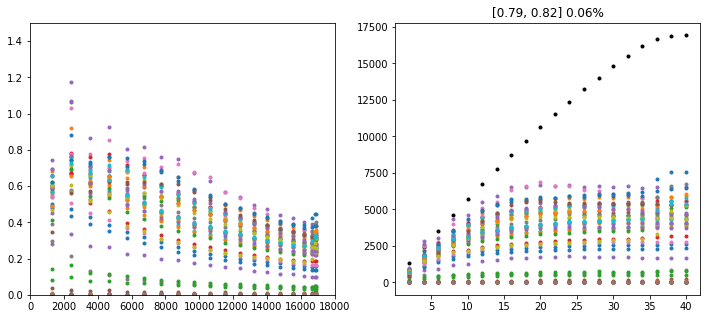

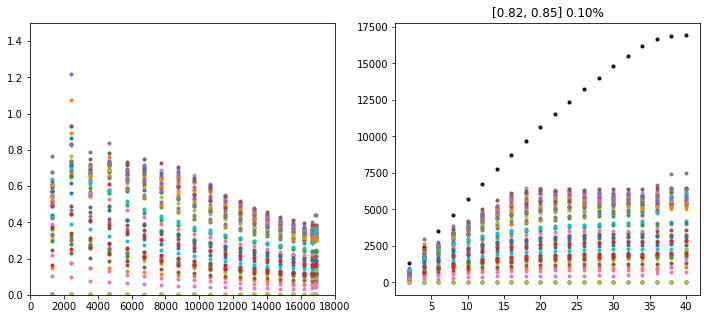

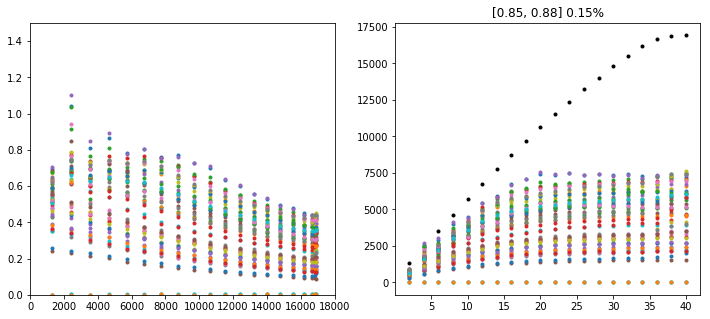

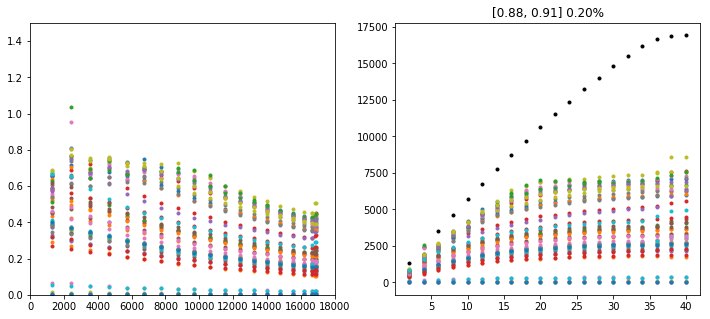

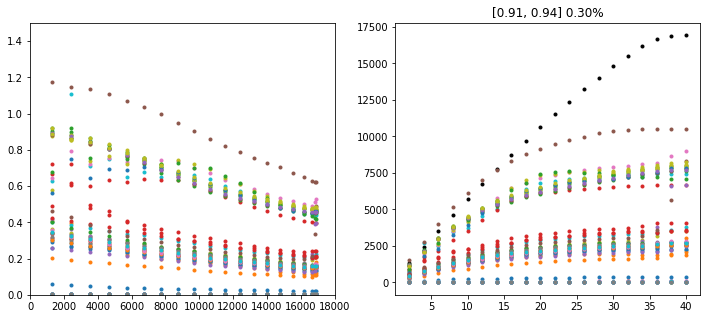

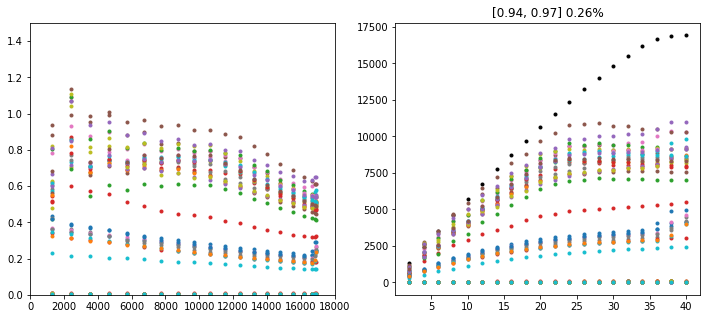

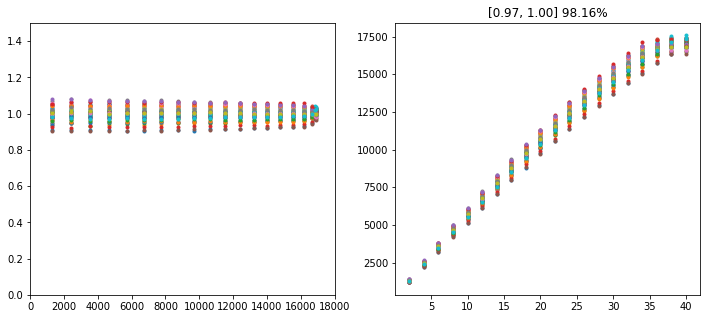

In [8]:
from numpy.random import randint

lims = arange(0.61, 1.01, 0.03)
sz = lims.shape[0]-1
meds = median(ims, axis=(0,1))

for i in range(sz):
    ndx = where((Rs < lims[i+1]) & (Rs > lims[i]))
    sz2 = ndx[0].shape[0]
    rands = randint(0, sz2, 50)
    f, ax = subplots(1,2, figsize=(12, 5))
    ax[1].plot(exps, meds, 'k.')
    title("[%.2f, %.2f] %.2f%%" % (lims[i], lims[i+1], float(sz2)/(2048*2048)*100))
    for j in range(50):
        arr = ims[ndx[0][rands[j]], ndx[1][rands[j]], :]
        arr2 = ims2[ndx[0][rands[j]], ndx[1][rands[j]], :]
        ax[0].plot(meds, arr/meds, '.')    
        ax[1].plot(exps, arr, '.')    
    
    #ax[0].plot(meds, meds, 'k--')
    ax[0].set_xlim([0, 1.8e4])
    ax[0].set_ylim([0, 1.5])
    show()

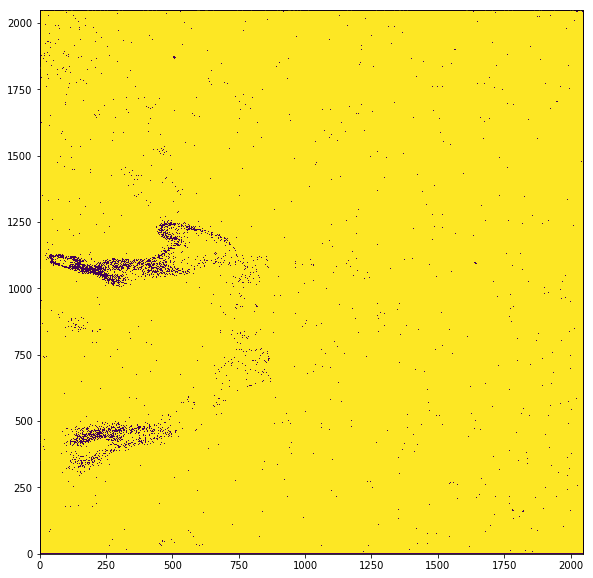

In [6]:
ndx = where(Rs < 0.97)
BPs = zeros([2048, 2048])+1
BPs[ndx] = 0
figure(figsize=(10,10))
imshow(BPs)
gca().invert_yaxis()
fits.PrimaryHDU(BPs).writeto("BP_Mask_R2.fits", overwrite=True)


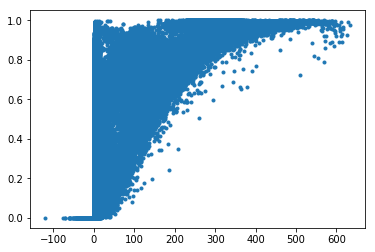

In [7]:
%matplotlib inline
plot(ravel(angs), ravel(Rs**2), '.')